In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:00<00:00, 1.55GB/s]
100% 149M/149M [00:00<00:00, 1.54GB/s]


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
import cv2
import time
from glob import glob

DATA_DIR = 'Brain Tumor MRI Dataset/'
IMAGE_SIZE = 128
BATCH_SIZE = 16
SEED = 42
EPOCHS = 10
NUM_CLASSES = 4

In [3]:
def get_cnn_classifier_model(input_shape):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [4]:
def get_label_from_path(file_path):
    return file_path.split(os.path.sep)[-2]

def load_and_preprocess_image(path, image_size):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    return img.astype(np.float32)

In [5]:
def image_generator(df, batch_size, image_size, class_map, augment=False):
    total_samples = len(df)
    indices = np.arange(total_samples)

    if augment:
         data_augmentation = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1)
        ])

    while True:
        np.random.shuffle(indices)
        for start in range(0, total_samples, batch_size):
            end = min(start + batch_size, total_samples)
            batch_indices = indices[start:end]

            X = np.empty((len(batch_indices), image_size, image_size, 3), dtype=np.float32)
            y = np.empty((len(batch_indices), 1), dtype=np.int32)

            for i, idx in enumerate(batch_indices):
                row = df.iloc[idx]
                X[i] = load_and_preprocess_image(row['path'], image_size)
                y[i] = class_map[row['label']]

            if augment:
                X = data_augmentation(X)

            yield X, y

In [6]:
training_paths = glob(os.path.join('Training', '*', '*.jpg'))
testing_paths = glob(os.path.join('Testing', '*', '*.jpg'))
all_paths = training_paths + testing_paths

df = pd.DataFrame({'path': all_paths})
df['label'] = df['path'].apply(get_label_from_path)

unique_labels = sorted(df['label'].unique())
CLASS_MAP = {label: i for i, label in enumerate(unique_labels)}
df['label_id'] = df['label'].map(CLASS_MAP)
NUM_CLASSES = len(unique_labels)

print(f"Total images found: {len(df)}")

df_train = df[df['path'].str.contains('Training')]
df_test = df[df['path'].str.contains('Testing')]

class_counts = df_train['label'].value_counts()
max_count = class_counts.max()

df_train_oversampled = [df_train[df_train['label'] == label].sample(max_count, replace=True, random_state=SEED)
                        for label in unique_labels]

df_train_balanced = pd.concat(df_train_oversampled).sample(frac=1, random_state=SEED).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=SEED).reset_index(drop=True)

STEPS_PER_EPOCH = len(df_train_balanced) // BATCH_SIZE
VALIDATION_STEPS = len(df_test) // BATCH_SIZE

print(f"Training samples (Balanced): {len(df_train_balanced)}, Test samples: {len(df_test)}")

Total images found: 7023
Training samples (Balanced): 6380, Test samples: 1311


In [7]:
def run_training_benchmark(device, df_train, epochs=1):
    with tf.device(device):
        model = get_cnn_classifier_model((IMAGE_SIZE, IMAGE_SIZE, 3))
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
            )

        start_time = time.time()
        gen = image_generator(df_train, BATCH_SIZE, IMAGE_SIZE, CLASS_MAP, augment=False)
        steps = len(df_train) // BATCH_SIZE
        model.fit(gen, steps_per_epoch=steps, epochs=epochs, verbose=0)
        end_time = time.time()

    return end_time - start_time, model

In [8]:
device_name = '/GPU:0' if tf.config.experimental.list_physical_devices('GPU') else '/CPU:0'
print(f"Benchmarking training time on {device_name} (1 epoch)...")
time_taken, final_model = run_training_benchmark(device_name, df_train_balanced, epochs=1)
print(f"Time taken on {device_name}: {time_taken:.2f} seconds.")

device_name = '/CPU:0' if tf.config.experimental.list_physical_devices('GPU') else print('No GPU available')
print(f"Benchmarking training time on {device_name} (1 epoch)...")
time_taken, final_model = run_training_benchmark(device_name, df_train_balanced, epochs=1)
print(f"Time taken on {device_name}: {time_taken:.2f} seconds.")

Benchmarking training time on /GPU:0 (1 epoch)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Time taken on /GPU:0: 15.60 seconds.
Benchmarking training time on /CPU:0 (1 epoch)...
Time taken on /CPU:0: 353.98 seconds.


In [14]:
353.98/15.60

22.691025641025643

Since GPU is almost 23 times faster i will use GPU

In [10]:
train_generator_aug = image_generator(df_train_balanced, BATCH_SIZE, IMAGE_SIZE, CLASS_MAP, augment=True)
test_generator = image_generator(df_test, BATCH_SIZE, IMAGE_SIZE, CLASS_MAP, augment=False)

with tf.device('/GPU:0'):
    final_model = get_cnn_classifier_model((IMAGE_SIZE, IMAGE_SIZE, 3))
    final_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy']
                        )

final_model.fit(
    train_generator_aug,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.5708 - loss: 1.0490 - val_accuracy: 0.7461 - val_loss: 0.6990
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.7790 - loss: 0.5695 - val_accuracy: 0.7029 - val_loss: 0.8415
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8106 - loss: 0.4815 - val_accuracy: 0.7994 - val_loss: 0.5350
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.8427 - loss: 0.4006 - val_accuracy: 0.7429 - val_loss: 0.7308
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.8565 - loss: 0.3828 - val_accuracy: 0.7948 - val_loss: 0.6015
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8573 - loss: 0.3522 - val_accuracy: 0.7776 - val_loss: 0.6184
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8832 - loss: 0.3059 - val_accuracy: 0.8309 - val_loss: 0.4140
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8781 - loss: 0.3118 -

In [11]:
print('loss,accuracy: ',final_model.evaluate(test_generator, steps=VALIDATION_STEPS, verbose=0))

loss,accuracy:  [0.48529326915740967, 0.8339768052101135]



--- 2. CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      glioma       0.88      0.79      0.83       296
  meningioma       0.78      0.59      0.67       302
     notumor       0.80      1.00      0.88       401
   pituitary       0.93      0.94      0.93       297

    accuracy                           0.84      1296
   macro avg       0.85      0.83      0.83      1296
weighted avg       0.84      0.84      0.83      1296


--- 3. CONFUSION MATRIX (Heatmap) ---


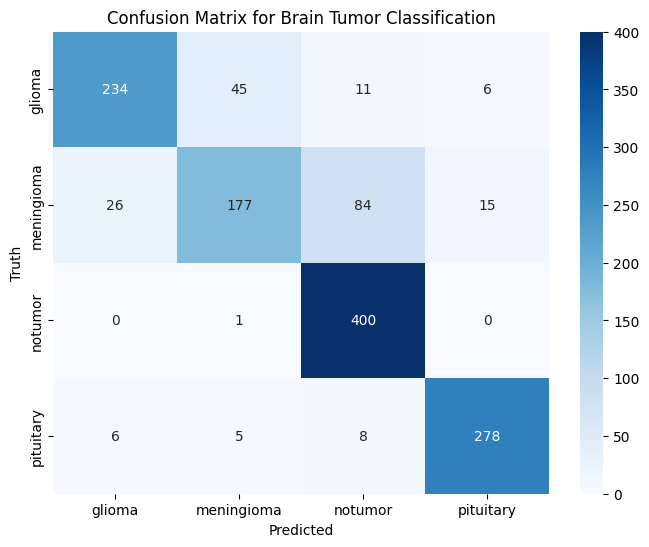

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

test_generator_for_pred = image_generator(df_test, BATCH_SIZE, IMAGE_SIZE, CLASS_MAP, augment=False)

y_true_list = []
y_pred_probs_list = []

for step in range(VALIDATION_STEPS):
    X_batch, y_batch = next(test_generator_for_pred)
    y_true_list.extend(y_batch.flatten())

    y_pred_batch = final_model.predict(X_batch, verbose=0)
    y_pred_probs_list.extend(y_pred_batch)

y_pred_probs = np.array(y_pred_probs_list)
y_true_labels = np.array(y_true_list)


y_predicted_labels = np.argmax(y_pred_probs, axis=1)

print("\n--- 2. CLASSIFICATION REPORT ---")
target_names = [label for label in CLASS_MAP.keys()]
print(classification_report(y_true_labels, y_predicted_labels, target_names=target_names, zero_division=0))

cm = confusion_matrix(y_true_labels, y_predicted_labels)

print("\n--- 3. CONFUSION MATRIX (Heatmap) ---")
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names,
           yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Brain Tumor Classification')
plt.show()

In [13]:
print("\n--- 4. Model Optimization for Deployment ---")

final_model.save('cnn_classification_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('cnn_quantized.tflite', 'wb') as f:
    f.write(tflite_quant_model)

original_size = os.path.getsize('cnn_classification_model.keras')
quant_size = len(tflite_quant_model)

print(f"Original Keras Model Size: {original_size / (1024*1024):.2f} MB")
print(f"Quantized TFLite Model Size: {quant_size / (1024*1024):.2f} MB")
print(f"Size Reduction: {((original_size - quant_size) / original_size) * 100:.2f}%")


--- 4. Model Optimization for Deployment ---
Saved artifact at '/tmp/tmp2zztwj9n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139938076761488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076758032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076769552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076761104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076770128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076763024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076768784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139938076763216: TensorSpec(shape=(), dtype=tf.resource, name=None)
Original Keras Model Size: 84.64 MB
Quantized TFLite Model Size: 7.06 MB
Size Reduction: 91.66%


In [25]:
def pred_new_imgs(img_path):
    CLASS_MAP = {0: 'glioma', 1: 'no tumor', 2: 'meningioma', 3: 'pituitary'}

    img_path = img_path
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = np.stack((img,)*3, axis=-1)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    plt.imshow(img[0])
    plt.title("Preprocessed Image (for model input)")
    plt.axis('off')
    plt.show()

    pred = final_model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_label = CLASS_MAP[pred_class]

    print(f"Predicted Label: {pred_label}")
    print(f"Confidence: {np.max(pred)*100:.2f}%")


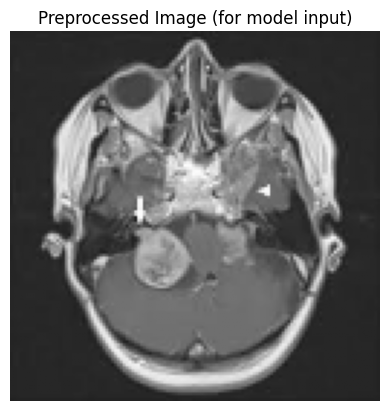

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: meningioma
Confidence: 88.33%


In [26]:
pred_new_imgs("meningioma_try.jpg")

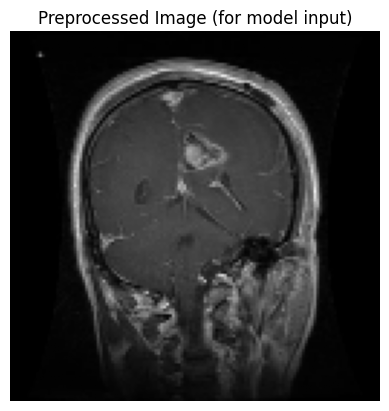

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: glioma
Confidence: 99.99%


In [30]:
pred_new_imgs("glioma_try.jpg")

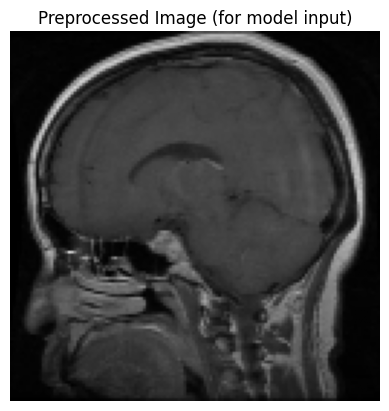

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Label: pituitary
Confidence: 98.92%


In [29]:
pred_new_imgs("pituitary_try.jpg")